# Load libaries

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import torch
from torchmetrics import MeanSquaredError
from iterativenn.nn_modules.Sequential1D import Sequential1D
import pytorch_lightning as pl

from iterativenn.utils.model_factory import ModelFactory_callback

# Introduction

This notebook is intended to be, in as simple a way as possible, a demonstration of growing an INN from a least squares problem.  There will be three solutions here:

1.  The least squares solution
2.  A classic MLP solution
3.  An INN solution grown from the least squares solution

We will get several benefits from this:

1.  This will be a baseline solution to any problem that can be phrased as a mapping from X to Y (e.g., MNIST, EM, graphs, etc.)
2.  It will be a sanity check on the MLP and INN solutions.  I.e., they should be able to learn the same thing as the least squares solution, if not better.
3.  It will be a starting place for any student working on similar problems. 


# Preliminaries

We want this notebook to be as simple and as general as possible, so all problem dependent code will be here.

In [2]:
# NOTE!!!!! This is setup for a small run, change SMALL_RUN to False to run on the full dataset
SMALL_RUN=True

if SMALL_RUN:
    # Small data for testing
    X_orig_train = torch.load('X_train.pt')
    Y_orig_train = torch.load('Y_train.pt')
    X_orig_test = torch.load('X_test.pt')
    Y_orig_test = torch.load('Y_test.pt')
    # Max epochs for both the MLP and INN
    MLP_max_epochs = 5
    INN_max_epochs = 5
else:
    # Large data for real use
    X_orig_train = torch.load('large_data/X_train.pt')
    Y_orig_train = torch.load('large_data/Y_train.pt')
    X_orig_test = torch.load('large_data/X_test.pt')
    Y_orig_test = torch.load('large_data/Y_test.pt')
    # Max epochs for both the MLP and INN
    MLP_max_epochs = 100
    INN_max_epochs = 100

# Note, the first and last later sizes are fixed by the number of columns in X and Y
MLP_layer_sizes = [X_orig_train.shape[1], 100, 70, 60, 40, 20, Y_orig_train.shape[1]]
MLP_activation = torch.nn.ELU()
MLP_learning_rate = 0.01

# Training size
# To make things faster, we'll only use a subset of the data
train_size = X_orig_train.shape[0]
test_size = X_orig_test.shape[0]

# the batch size to use for both INN and MLP
batch_size = 128


# number of hidden values in the INN
INN_hidden_size = 112
# number of hidden values in the INN
INN_iterations = 3
# activation function for the INN
INN_activation = 'ELU'
# learning rate for the INN
INN_learning_rate = 0.01

# Setup

We do some basic setup and sanity checks.

In [3]:
# We have the correct number of training and test samples
assert X_orig_train.shape[0] == Y_orig_train.shape[0]
assert X_orig_test.shape[0] == Y_orig_test.shape[0]

# We have the same number of features in the training and test sets
assert X_orig_train.shape[1] == X_orig_test.shape[1]
assert Y_orig_train.shape[1] == Y_orig_test.shape[1]

In [4]:
print('training data orig shape:')
print (f'X {X_orig_train.shape}')
print (f'Y {Y_orig_train.shape}')

print('testing data orig shape:')
print (f'X {X_orig_test.shape}')
print (f'Y {Y_orig_test.shape}')

training data orig shape:
X torch.Size([3260, 160])
Y torch.Size([3260, 1])
testing data orig shape:
X torch.Size([1630, 160])
Y torch.Size([1630, 1])


In [5]:
perm = torch.randperm(X_orig_train.size(0))
idx = perm[:train_size]
X_train = X_orig_train[idx, :]
Y_train = Y_orig_train[idx, :]

In [6]:
perm = torch.randperm(X_orig_test.size(0))
idx = perm[:test_size]
X_test = X_orig_test[idx, :]
Y_test = Y_orig_test[idx, :]

In [7]:
print('training data shape:')
print (f'X {X_train.shape}')
print (f'Y {Y_train.shape}')

print('testing data shape:')
print (f'X {X_test.shape}')
print (f'Y {Y_test.shape}')

training data shape:
X torch.Size([3260, 160])
Y torch.Size([3260, 1])
testing data shape:
X torch.Size([1630, 160])
Y torch.Size([1630, 1])


# Least squares solution

In [8]:
def least_squares(X, Y, device=None, dtype=None):
    """
    Returns a Linear object that is the least squares solution to the problem X -> Y.
    This function initializes the initial weights "weight_0" and the update "U" 
    to be the optimal least squares solution to the linear regression problem
    which maps the input X to the output Y.  This is done by computing

    :math:`
        XW=Y\\
        X^T X W = X^T Y \\
        (X^T X)^{-1} X^T X W = (X^T X)^{-1} X^T Y \\
        W = (X^T X)^{-1} X^T Y 
    `
    Args:
    X: A tensor of shape (N, D) where N is the number of samples and D is the number of features.
    Y: A tensor of shape (N, K) where N is the number of samples and K is the number of outputs.
    device: The device to use for the Linear object.
    dtype: The dtype to use for the Linear object.
    """
    X_size = X.size()[1]
    Y_size = Y.size()[1]
    A = torch.nn.Linear(in_features=X_size, out_features=Y_size, bias=False, device=device, dtype=dtype)
    with torch.no_grad():
        W_init = (torch.inverse(X.T @ X)@X.T@Y).T
        # The requires_grad=Fase is important, otherwise the gradient will be computed when we don't want it to.
        A.weight[:, :] = W_init
    return A

In [9]:
least_squares_module = least_squares(X_train, Y_train)

In [10]:
def to_1D(Z):
    """Given a tensor Z, returns a 1D tensor with the same number of rows as Z,
    but with each row projected onto a single column.

    Args:
        Z (Tensor): the possibly multi-dimensional tensor to project onto a single dimension.

    Returns:
        Tensor : A 1D projection of Z.
    """
    Z = Z.detach()
    if Z.shape[1] == 1:
        return Z.reshape(-1)
    else:
        U,S,V = torch.pca_lowrank(Z)
        Z_1D = matmul(A, V[:, :k])
        return Z_1D.reshape(-1)

Text(0, 0.5, 'Predicted')

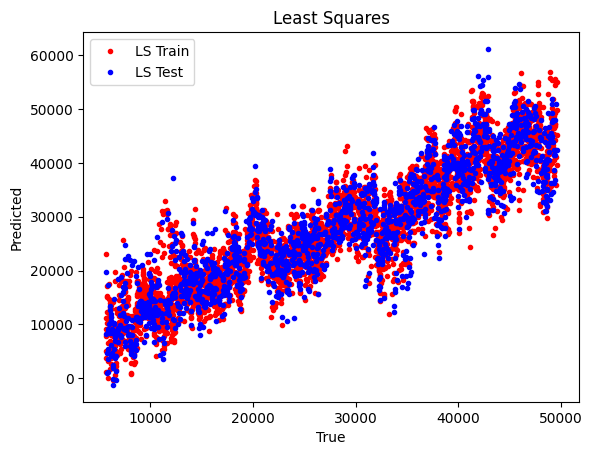

In [11]:
plt.plot(to_1D(Y_train), to_1D(least_squares_module(X_train)), '.r')
plt.plot(to_1D(Y_test), to_1D(least_squares_module(X_test)), '.b')
plt.title('Least Squares')
plt.legend(['LS Train', 'LS Test'])
plt.xlabel('True')
plt.ylabel('Predicted')

In [12]:
rmse = MeanSquaredError(squared=False)
print(f'Training error : {rmse(least_squares_module(X_train), Y_train).item()}')
print(f'Testing error : {rmse(least_squares_module(X_test), Y_test).item()}')

Training error : 5532.669921875
Testing error : 5884.7216796875


# MLP solution

In [13]:
# Sequential1D is just a wrapper around nn.Sequential that
# records the input and output sizes of the network.  This is useful
# for the INN solution below as the MLP can be used as a block in an INN.
# However, the as far as this part is concerned, it is identical to nn.Sequential.
MLP = Sequential1D(in_features=MLP_layer_sizes[0],
                   out_features=MLP_layer_sizes[-1]) 

for i in range(len(MLP_layer_sizes)-1):
    MLP.add_module(f'linear{i}', 
                   torch.nn.Linear(MLP_layer_sizes[i], MLP_layer_sizes[i+1]))
    # always end with a linear layer
    if i < len(MLP_layer_sizes)-2:        
        MLP.add_module(f'activation{i}', 
                       MLP_activation)


In [14]:
class LitModule(pl.LightningModule):
    def __init__(self, module):
        super().__init__()
        self.module = module
        self.losses = []
    
    def forward(self, X):
        return self.module(X)

    def training_step(self, batch, batch_idx):
        X,Y = batch
        Y_hat = self.module(X)
        loss = torch.nn.functional.mse_loss(Y_hat, Y)
        self.losses.append(float(loss))
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.RMSprop(self.parameters(), lr=MLP_learning_rate)
        return optimizer

In [15]:
mlp_module = LitModule(MLP)
dataset = torch.utils.data.TensorDataset(X_train, Y_train)

In [16]:
MLP_trainable_params = sum(p.numel() for p in mlp_module.parameters() if p.requires_grad)
print(f'MLP_trainable_params: {MLP_trainable_params}')

MLP_trainable_params: 30711


In [17]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
trainer = pl.Trainer(max_epochs=MLP_max_epochs,
                     devices=1 if torch.cuda.is_available() else None,
                     accelerator='auto')
trainer.fit(model=mlp_module, train_dataloaders=train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type         | Params
----------------------------------------
0 | module | Sequential1D | 30.7 K
----------------------------------------
30.7 K    Trainable params
0         Non-trainable params
30.7 K    Total params
0.123     Total estimated model params size (MB)
/home/rcpaffenroth/projects/iterativenn/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 3

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


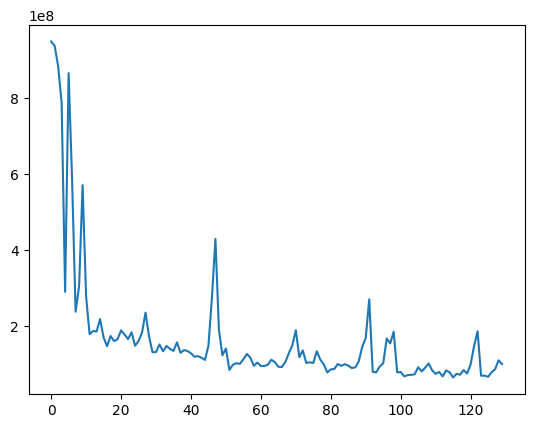

In [18]:
plt.plot(mlp_module.losses)

Text(0, 0.5, 'Predicted')

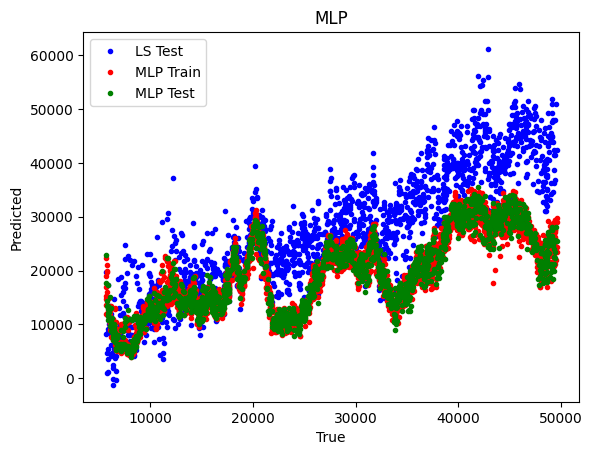

In [19]:
plt.plot(to_1D(Y_test), to_1D(least_squares_module(X_test)), '.b')
plt.plot(to_1D(Y_train), to_1D(mlp_module(X_train)), '.r')
plt.plot(to_1D(Y_test), to_1D(mlp_module(X_test)), '.g')
plt.legend(['LS Test', 'MLP Train', 'MLP Test', ])
plt.title('MLP')
plt.xlabel('True')
plt.ylabel('Predicted')

In [20]:
rmse = MeanSquaredError(squared=False)
print(f'Training error : {rmse(mlp_module(X_train), Y_train).item()}')
print(f'Testing error : {rmse(mlp_module(X_test), Y_test).item()}')

Training error : 11660.0751953125
Testing error : 11987.888671875


# INN solution

In [21]:
default_kwargs = {'block_type':'W', 'initialization_type':'G=0.0,0.01', 'trainable':True, 'bias':False}
default_kwargs_0 = {'block_type':'W', 'initialization_type':'G=0.0,0.0', 'trainable':True, 'bias':False}


default_module = 'MaskedLinear.from_description'
previous_module = least_squares_module
m = X_train.shape[1]
n = Y_train.shape[1]
k = INN_hidden_size
 
cfg = {
    "model_type": "sequential2D",   
    "in_features_list": [m, n, k], 
    "out_features_list": [m, n, k], 

    "block_types": [
        ['Identity',     'Module',       default_module],
        [None,           None,           default_module],
        [None,           default_module, default_module],
    ],
    "block_kwargs": [
        [None,           {'module':previous_module, 'trainable': False}, default_kwargs],
        [None,           None,                                           default_kwargs],
        [None,           default_kwargs_0,                               default_kwargs],
    ],

    "activations" : ['Identity', 'Identity', INN_activation],
    "activation_sizes" : [m, n, k],
    "callbacks": {
        "loss": {
            "func": "MSELoss",
            "idx_list" : range(m, m+n),
            # Change this to 'all' to use all the losses during the iteration
            # "sequence_position": 'all',
            "sequence_position": 'last',
        },
        "initialization": {
            "func": "zeros",
            "size": m+n+k,
        },
        "data": {
            "func": "insert",
            "idx_list": range(0, m),
            "flatten_input": False,
        },
        "output": {
            "func": "all",
            "idx_list" : range(m, m+n)
        },
    }

}

In [22]:
class LitIteratedModule(pl.LightningModule):
    def __init__(self, module, callbacks, iterations=1):
        super().__init__()
        self.module = module
        self.callbacks = callbacks
        self.iterations = iterations
        self.losses = []
    
    def forward(self, X):
        Z = self.callbacks.initialization(X.device, rows=X.shape[0])
        Z = self.callbacks.data(Z, X)
        for i in range(self.iterations):
            Z = self.module(Z)
        return self.callbacks.output(Z, 0, None, None, None)

    def training_step(self, batch, batch_idx):
        X,Y = batch
        Z = self.callbacks.initialization(X.device, rows=X.shape[0])
        Z = self.callbacks.data(Z, X)
        # Note, the lost is returned for every iteration.
        # Sometimes it might be 0 (e.g., when loss type is 'last')
        loss = 0
        for i in range(self.iterations):
            Z = self.module(Z)        
            loss += self.callbacks.loss(Z, Y)
        self.losses.append(float(loss))
        return loss    

    def configure_optimizers(self):
        optimizer = torch.optim.RMSprop(self.parameters(), lr=INN_learning_rate)
        return optimizer

In [23]:
# This is an IteratedModule, which is a wrapper around a module
module = ModelFactory_callback(cfg)
inn_module = LitIteratedModule(module.model, module.callbacks, iterations=INN_iterations)

In [24]:
INN_trainable_params = sum(p.numel() for p in inn_module.parameters() if p.requires_grad)
print(f'INN_trainable_params: {INN_trainable_params}')

INN_trainable_params: 30688


In [25]:
print(f'predicted INN_trainable_params: {m*k+2*n*k+k**2}')

predicted INN_trainable_params: 30688


In [26]:

dataset = torch.utils.data.TensorDataset(X_train, Y_train)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
trainer = pl.Trainer(max_epochs=INN_max_epochs,
                devices=1 if torch.cuda.is_available() else None,
                accelerator='auto')
trainer.fit(model=inn_module, train_dataloaders=train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type         | Params
----------------------------------------
0 | module | Sequential1D | 92.2 K
----------------------------------------
30.7 K    Trainable params
61.5 K    Non-trainable params
92.2 K    Total params
0.369     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


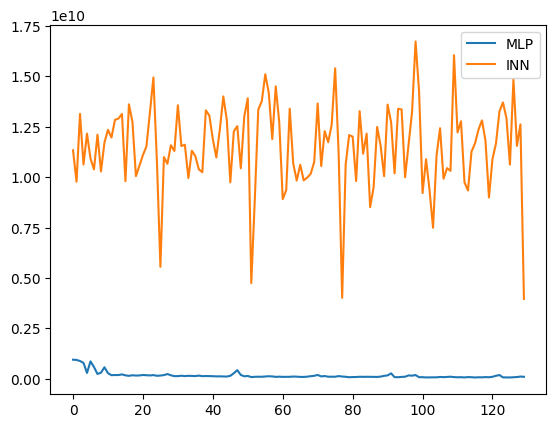

In [27]:
plt.plot(mlp_module.losses)
plt.plot(inn_module.losses)
plt.legend(['MLP', 'INN'])

In [28]:
print(torch.mean(torch.Tensor(inn_module.losses[0:1000])))
print(torch.mean(torch.Tensor(inn_module.losses[1000:2000])))
print(torch.mean(torch.Tensor(inn_module.losses[9000:10000])))

tensor(1.1516e+10)
tensor(nan)
tensor(nan)


Text(0, 0.5, 'Predicted')

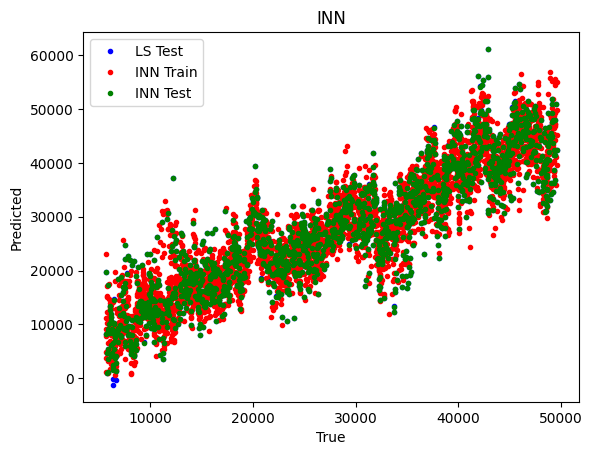

In [29]:
plt.plot(to_1D(Y_test), to_1D(least_squares_module(X_test)), '.b')
plt.plot(to_1D(Y_train), to_1D(inn_module(X_train)), '.r')
plt.plot(to_1D(Y_test), to_1D(inn_module(X_test)), '.g')
plt.legend(['LS Test', 'INN Train', 'INN Test', ])
plt.title('INN')
plt.xlabel('True')
plt.ylabel('Predicted')

# INN solution (random start)

In [30]:
default_kwargs = {'block_type':'W', 'initialization_type':'G=0.0,0.01', 'trainable':True, 'bias':False}
default_kwargs_0 = {'block_type':'W', 'initialization_type':'G=0.0,0.0', 'trainable':True, 'bias':False}
non_trainable_kwargs = {'block_type':'W', 'initialization_type':'G=0.0,1.0', 'trainable':False, 'bias':False}

default_module = 'MaskedLinear.from_description'
previous_module = least_squares_module
m = X_train.shape[1]
n = Y_train.shape[1]
k = INN_hidden_size
 
cfg = {
    "model_type": "sequential2D",   
    "in_features_list": [m, n, k], 
    "out_features_list": [m, n, k], 

    "block_types": [
        ['Identity',     default_module, default_module],
        [None,           None,           default_module],
        [None,           default_module, default_module],
    ],
    "block_kwargs": [
        [None,           non_trainable_kwargs,      default_kwargs],
        [None,           None,                      default_kwargs],
        [None,           default_kwargs_0,          default_kwargs],
    ],

    "activations" : ['Identity', 'Identity', INN_activation],
    "activation_sizes" : [m, n, k],
    "callbacks": {
        "loss": {
            "func": "MSELoss",
            "idx_list" : range(m, m+n),
            # Change this to 'all' to use all the losses during the iteration
            # "sequence_position": 'all',
            "sequence_position": 'last',
        },
        "initialization": {
            "func": "zeros",
            "size": m+n+k,
        },
        "data": {
            "func": "insert",
            "idx_list": range(0, m),
            "flatten_input": False,
        },
        "output": {
            "func": "all",
            "idx_list" : range(m, m+n)
        },
    }

}

In [31]:
class LitIteratedModule(pl.LightningModule):
    def __init__(self, module, callbacks, iterations=1):
        super().__init__()
        self.module = module
        self.callbacks = callbacks
        self.iterations = iterations
        self.losses = []
    
    def forward(self, X):
        Z = self.callbacks.initialization(X.device, rows=X.shape[0])
        Z = self.callbacks.data(Z, X)
        for i in range(self.iterations):
            Z = self.module(Z)
        return self.callbacks.output(Z, 0, None, None, None)

    def training_step(self, batch, batch_idx):
        X,Y = batch
        Z = self.callbacks.initialization(X.device, rows=X.shape[0])
        Z = self.callbacks.data(Z, X)
        # Note, the lost is returned for every iteration.
        # Sometimes it might be 0 (e.g., when loss type is 'last')
        loss = 0
        for i in range(self.iterations):
            Z = self.module(Z)        
            loss += self.callbacks.loss(Z, Y)
        self.losses.append(float(loss))
        return loss    

    def configure_optimizers(self):
        optimizer = torch.optim.RMSprop(self.parameters(), lr=INN_learning_rate)
        return optimizer

In [32]:
# This is an IteratedModule, which is a wrapper around a module
module = ModelFactory_callback(cfg)
inn_rand_module = LitIteratedModule(module.model, module.callbacks, iterations=INN_iterations)

In [33]:
INN_trainable_params = sum(p.numel() for p in inn_rand_module.parameters() if p.requires_grad)
print(f'INN_trainable_params: {INN_trainable_params}')

INN_trainable_params: 30848


In [34]:
print(f'predicted INN_trainable_params: {m*k+2*n*k+k**2}')

predicted INN_trainable_params: 30688


In [35]:

dataset = torch.utils.data.TensorDataset(X_train, Y_train)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
trainer = pl.Trainer(max_epochs=INN_max_epochs,
                devices=1 if torch.cuda.is_available() else None,
                accelerator='auto')
trainer.fit(model=inn_rand_module, train_dataloaders=train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type         | Params
----------------------------------------
0 | module | Sequential1D | 92.5 K
----------------------------------------
30.8 K    Trainable params
61.7 K    Non-trainable params
92.5 K    Total params
0.370     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


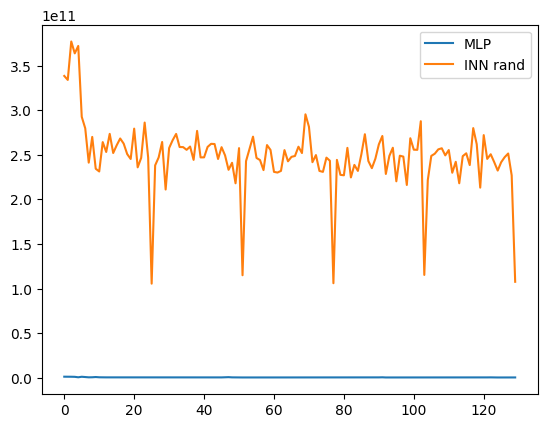

In [36]:
plt.plot(mlp_module.losses)
plt.plot(inn_rand_module.losses)
plt.legend(['MLP', 'INN rand'])

In [37]:
print(torch.mean(torch.Tensor(inn_rand_module.losses[0:1000])))
print(torch.mean(torch.Tensor(inn_rand_module.losses[1000:2000])))
print(torch.mean(torch.Tensor(inn_rand_module.losses[9000:10000])))

tensor(2.4890e+11)
tensor(nan)
tensor(nan)


Text(0, 0.5, 'Predicted')

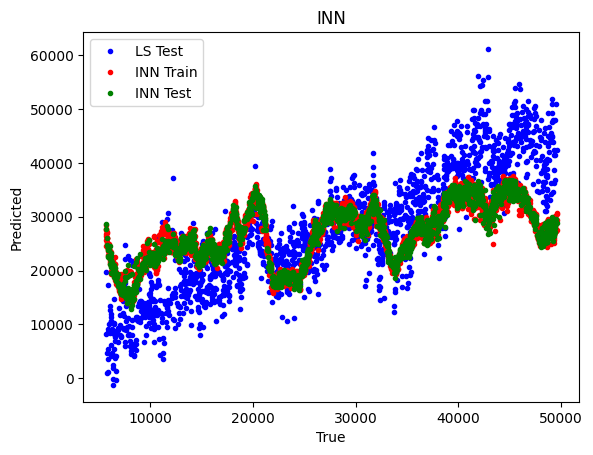

In [38]:
plt.plot(to_1D(Y_test), to_1D(least_squares_module(X_test)), '.b')
plt.plot(to_1D(Y_train), to_1D(inn_rand_module(X_train)), '.r')
plt.plot(to_1D(Y_test), to_1D(inn_rand_module(X_test)), '.g')
plt.legend(['LS Test', 'INN Train', 'INN Test', ])
plt.title('INN')
plt.xlabel('True')
plt.ylabel('Predicted')

# Summary

In [39]:
rmse = MeanSquaredError(squared=False)
print('================================')
print(f'LS Training error : {rmse(least_squares_module(X_train), Y_train).item()}')
print(f'LS Testing error : {rmse(least_squares_module(X_test), Y_test).item()}')
print('================================')
print(f'MLP trainable params: {MLP_trainable_params}')
print(f'MLP Training error : {rmse(mlp_module(X_train), Y_train).item()}')
print(f'MLP Testing error : {rmse(mlp_module(X_test), Y_test).item()}')
print('================================')
print(f'INN trainable params: {INN_trainable_params}')
print(f'INN Training error : {rmse(inn_module(X_train), Y_train).item()}')
print(f'INN Testing error : {rmse(inn_module(X_test), Y_test).item()}')
print('================================')
print(f'INN_rand trainable params: {INN_trainable_params}')
print(f'INN_rand Training error : {rmse(inn_rand_module(X_train), Y_train).item()}')
print(f'INN_rand Testing error : {rmse(inn_rand_module(X_test), Y_test).item()}')
print('================================')

LS Training error : 5532.669921875
LS Testing error : 5884.7216796875
MLP trainable params: 30711
MLP Training error : 11660.0751953125
MLP Testing error : 11987.888671875
INN trainable params: 30848
INN Training error : 5531.529296875
INN Testing error : 5879.21826171875
INN_rand trainable params: 30848
INN_rand Training error : 10126.5419921875
INN_rand Testing error : 10117.0419921875
